In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace, udf, mean, split, desc, min, max
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, PCA, StringIndexer, MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import pandas as pd

1.Imports necessary PySpark SQL functions to handle and
   process data (col, mean, split, desc).
2.Defines data types (DoubleType, IntegerType) for
  numerical processing.
3.Loads ML features and preprocessing tools
  (VectorAssembler, StandardScaler, OneHotEncoder, PCA, etc.).
4.Includes machine learning models like
   RandomForestRegressor and RandomForestClassifier.
5.Implements model evaluatio(RegressionEvaluator)     and   clustering (BisectingKMeans).
6.Uses hyperparameter tuning (ParamGridBuilder,
     CrossValidator) for better model optimization.
7.Matplotlib and Pandas for data visualization and
   result analysis.

**Initialize Spark Session**

In [37]:
spark = SparkSession.builder \
    .appName("FIFA18_PlayerPerformance") \
    .getOrCreate()


**Load and Merge Datasets**
Loads multiple datasets in CSV format (spark.read.csv).
Joins them on "ID" using inner join, ensuring only matching records are merged.Removes duplicate columns to avoid redundant data.Converts the dataframe from Spark to Pandas and back to Spark to handle duplicate removal.

In [38]:
# Load datasets
complete_df = spark.read.csv("/content/CompleteDataset.csv", header=True, inferSchema=True)
attribute_df = spark.read.csv("/content/PlayerAttributeData.csv", header=True, inferSchema=True)
personal_df = spark.read.csv("/content/PlayerPersonalData.csv", header=True, inferSchema=True)
position_df = spark.read.csv("/content/PlayerPlayingPositionData.csv", header=True, inferSchema=True)

# Join datasets using "ID" column
df = complete_df \
    .join(attribute_df, on="ID", how="inner") \
    .join(personal_df, on="ID", how="inner") \
    .join(position_df, on="ID", how="inner")
# Remove duplicate columns
df = df.toPandas()
df = df.loc[:, ~df.columns.duplicated()]
df = spark.createDataFrame(df)

# Print column count
print(f"Total number of columns: {len(df.columns)}")

Total number of columns: 76


**Handle Missing Values**

Handles salary values by removing currency symbols (€).
Converts M (millions) and K (thousands) to numerical values.Registers User Defined Function (UDF) in Spark.
Applies transformation to convert "Value" and "Wage" to numeric types.

In [39]:
# Function to convert monetary values (€105M → 105000000)
def convert_money(value):
    if value is None or value == "":
        return None
    value = value.replace("€", "").replace("M", "000000").replace("K", "000")
    return float(value)

# Register UDF
convert_money_udf = udf(convert_money, DoubleType())

# Apply transformations
df = df.withColumn("Value", convert_money_udf(col("Value")))
df = df.withColumn("Wage", convert_money_udf(col("Wage")))

df.select("Value", "Wage").show(10)

+------+--------+
| Value|    Wage|
+------+--------+
|  95.5|565000.0|
|1.05E8|565000.0|
|1.23E8|280000.0|
| 9.7E7|510000.0|
| 6.1E7|230000.0|
| 9.2E7|355000.0|
|  64.5|215000.0|
|  90.5|295000.0|
| 7.9E7|340000.0|
| 7.7E7|275000.0|
+------+--------+
only showing top 10 rows



Finds columns with values like "80-90".
Splits the values into two numbers and computes the mean.Computes mean value for missing numerical columns and fills missing values.Finds most common (mode) value for missing categorical data and fills them.If more than 50% of values are missing, the column is dropped.

In [40]:
def fix_range_values(df):
    for column in df.columns:
        df = df.withColumn(column, when(
            col(column).rlike("^[0-9]+[-+][0-9]+$"),  # Check for "X-Y" or "X+Y" format
            (split(col(column), "[-+]").getItem(0).cast("int") +
             split(col(column), "[-+]").getItem(1).cast("int")) / 2  # Compute mean of values
        ).otherwise(col(column)))
    return df

In [41]:
df = fix_range_values(df)

In [42]:
def fill_missing_numerical(df):
    for column in df.columns:
        # Check if column is numeric
        if dict(df.dtypes)[column] in ['int', 'double']:
            mean_value = df.select(mean(col(column))).collect()[0][0]
            if mean_value is not None:  # Only fill if mean is valid
                df = df.fillna({column: mean_value})
    return df
def fill_missing_categorical(df):
    for column in df.columns:
        # Check if column is categorical (string type)
        if dict(df.dtypes)[column] == 'string':
            mode_row = df.groupBy(column).count().orderBy(desc("count")).first()

            if mode_row and mode_row[0] is not None:  # Check if mode exists
                df = df.fillna({column: mode_row[0]})
            else:
                df = df.fillna({column: "Unknown"})  # Fill with 'Unknown' if no mode found

    return df
def drop_high_missing_columns(df, threshold=0.5):
    total_rows = df.count()
    for column in df.columns:
        missing_count = df.filter(col(column).isNull()).count()
        if (missing_count / total_rows) > threshold:  # Drop if more than 50% missing
            df = df.drop(column)
    return df
df = fill_missing_numerical(df)
df = fill_missing_categorical(df)
df = drop_high_missing_columns(df)

**One-Hot Encoding Categorical Features**

Converts categorical variables into numerical labels using StringIndexer.Applies One-Hot Encoding to transform categorical columns into numerical vectors.

In [43]:
categorical_columns = ["Nationality", "Club", "Preferred Positions"]
indexed_columns = [col + "_index" for col in categorical_columns]
encoded_columns = [col + "_encoded" for col in categorical_columns]

indexers = [StringIndexer(inputCol=col, outputCol=idx_col, handleInvalid="keep") for col, idx_col in zip(categorical_columns, indexed_columns)]
encoders = [OneHotEncoder(inputCol=idx_col, outputCol=enc_col) for idx_col, enc_col in zip(indexed_columns, encoded_columns)]

pipeline = Pipeline(stages=indexers + encoders)
df = pipeline.fit(df).transform(df)


**Convert Numerical Columns from String to Double**

FIFA 18  dataset stores numerical attributes as strings (e.g., "78+" or "85-90"), which cannot be used directly in ML models.This step ensures all skill attributes are numerical so they can be processed correctly.

In [44]:
# Convert skill attributes from string to numerical
skill_columns = ["Acceleration", "Aggression", "Agility", "Balance", "Ball control", "Composure", "Crossing",
    "Curve", "Dribbling", "Finishing", "Free kick accuracy", "GK diving", "GK handling", "GK kicking",
    "GK positioning", "GK reflexes", "Heading accuracy", "Interceptions", "Jumping", "Long passing",
    "Long shots", "Marking", "Penalties", "Positioning", "Reactions", "Short passing", "Shot power",
    "Sliding tackle", "Sprint speed", "Stamina", "Standing tackle", "Strength", "Vision", "Volleys"]

for col_name in skill_columns:
    df = df.withColumn(col_name, regexp_replace(col(col_name), "[^0-9]", "").cast("double"))

In [45]:
feature_columns = ["Dribbling", "Long passing","Short passing", "Agility", "Balance", "Sprint speed", "Ball control",
            "Reactions", "Stamina", "Vision", "Composure", "Strength", "Age", "Potential"]



**Normalization & Standardization**

Converts multiple individual numerical columns into a single feature vector.Brings all features to the same scale, preventing large-valued features from dominating.Improves model performance, especially for algorithms sensitive to magnitude differences.

In [46]:
# Assemble features before normalization
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# Apply MinMaxScaler for Normalization (scales values between 0 and 1)
scaler = MinMaxScaler(inputCol="features", outputCol="normalizedFeatures")
df = scaler.fit(df).transform(df)

# Apply StandardScaler for Standardization (zero mean and unit variance)
std_scaler = StandardScaler(inputCol="normalizedFeatures", outputCol="scaledFeatures", withMean=True, withStd=True)
df = std_scaler.fit(df).transform(df)

# Apply PCA for dimensionality reduction
pca = PCA(k=10, inputCol="scaledFeatures", outputCol="pcaFeatures")
df = pca.fit(df).transform(df)


**Train & Evaluate Machine Learning Models**
Splits the dataset (80% Train, 20% Test).
Trains a Random Forest Regression Model.
Evaluates performance using RMSE (Root Mean Square Error).

In [47]:
# Split dataset
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Train Random Forest Model
rf = RandomForestRegressor(featuresCol="pcaFeatures", labelCol="Overall", numTrees=100)
rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)

# Evaluate model performance using RMSE
evaluator = RegressionEvaluator(labelCol="Overall", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rf_rmse}")


Random Forest RMSE: 3.047015244641721


**Hyperparameter Tuning with Cross-Validation**

Bellow code performs hyperparameter tuning for a Random Forest model using Cross-Validation (CV) to find the best combination of tree count (numTrees) and tree depth (maxDepth). It trains multiple models with different parameter settings on train_df, selects the best model, and makes predictions on test_df. Finally, it evaluates the Root Mean Squared Error (RMSE) to measure the model's prediction accuracy.

In [48]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100])
             .addGrid(rf.maxDepth, [5, 10])
             .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cv_model = cv.fit(train_df)
cv_predictions = cv_model.transform(test_df)
cv_rmse = evaluator.evaluate(cv_predictions)
print(f"Tuned Random Forest RMSE: {cv_rmse}")


Tuned Random Forest RMSE: 2.0744690567514863


**Visualizing Model Performance**

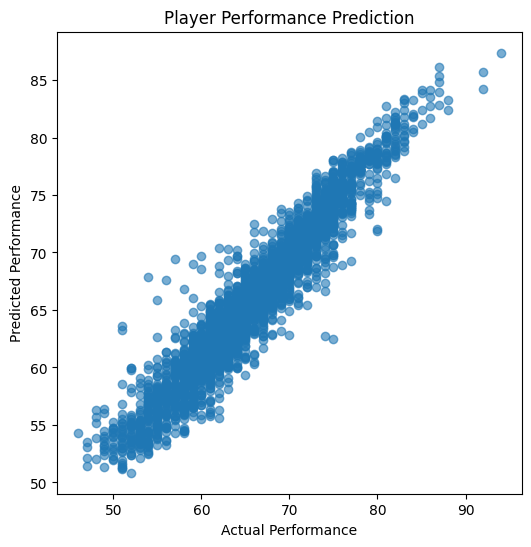

In [49]:
predictions_pd = cv_predictions.select("Overall", "prediction").toPandas()

plt.figure(figsize=(6,6))
plt.scatter(predictions_pd["Overall"], predictions_pd["prediction"], alpha=0.6)
plt.xlabel("Actual Performance")
plt.ylabel("Predicted Performance")
plt.title("Player Performance Prediction")
plt.show()


The scatter plot helps visualize how well the model predicts player performance, with points aligning along the diagonal indicating accurate predictions. By training on historical player data, the model can track performance trends over multiple seasons, identifying rising stars (above the line) or declining players (below the line). This approach allows teams to forecast future player ratings based on skill evolution, training impact, and aging effects